# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 3 - Training a PyTorch ResNet152 convolutional neural network (CNN) using Torchvision pre-trained network on ImageNet database.

This notebook shows how to prepare datasets for training a Convolutional Neural Network using the CUB-200-2011 database of birds.

The previous notebooks sorted the data into an organised filing system for use with Torchvision data loaders and investigated the type of data and class sampling densities of the training and test sets.

This is the third stage of our roadmap for building and understanding a birds image classifier:

![RoadMapImage](../docs/birds_roadmap.png)

This notebook is now going to show: 

    1. How to set up a dataloader using an augmentation workflow (as in Part 1) for use in providing images to our network for training.
    
    2. How to load a common network architecture, such as ResNet152, and load pretrained weights into the netowrk, using the models supplied in the PyTorch Torchvision module.
    
    3. How to manipulate the network structure to re-engineer the ouput classifier layer so that it suits the purposes of our problem.
    
    4. How to set up the required objects that are needed for training a neural network, in addition to the neural network model object itself. This includes:
        a. Loss function.
        b. Optimizer.
        c. Learning rate scheduler.
        d. training function.

## Notebook setup

### Modules and externals

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import time
import copy
import pickle
from tqdm import tqdm

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import save_model_dict, save_model_full, unpickle
from cub_tools.transforms import makeDefaultTransforms

### Runtime setup

In [2]:
# Script runtime options
model_name = 'resnet152'
model_func = models.resnet152
root_dir = '../data'
data_dir = os.path.join(root_dir,'images')
working_dir = os.path.join('../models/classification', model_name)
batch_size = 16
num_workers = 4
num_epochs = 40

## Load the dataset loaders

As with the visualisation section (001 Notebook), we need to create a loader for importing the images sets for both training and testing/validation purposes. As with all algorithm development and training, we must be careful to separate our data into separate training and test sets, such that we can gain a (hopefully) unbiased assessment of the model performance by testing the predictive power of the model with known images of birds. These images must not have been using the training process, as any images that will be presented to network during deployment will not have been seen by the network before. We want to assess what the performance of the network will be when it is presented with images of the same class, but not the same exact image, that it has been trained on. Only then can we get a fair assessment of the likely performance of the algorithm.

In [3]:
os.makedirs(working_dir, exist_ok=True)

### Load the augmention transforms

Data augmentation, a process we looked at in the previous notebook, is a process which applies random translations to the input images during each Epoch of training, such that every time the network sees each image, it is not the exact same representation of that image. These transforms are loaded from a preset function, which determines both the train and validation transformations.

In [4]:
# Get data transforms
data_transforms = makeDefaultTransforms()

Firstly, we create the dataset and dataloader objects by using the Torchvision dataset tools.

As we have organised our image files into train and test directories already, we simply give the path to the dataset object function datasets.ImageFolder of Torchvision and it creates a Torch dataset object, with all the images. The images have also been arranged into sub-directories of image class, the function attributes the class label of the image from the directory name. The image dataset object also carries with the loading process and any augmentation transforms that are to be applied to the training and test data.

The dataset objects can be used to be turned into batching image loaders, which can be used as the process which controls the inputs that are loaded into the neural network during training and testing. The **batch size** determines the number of images that are served up to the network in a **mini batch**, an iteration. The number of mini batches is determined by the number of images, and is divided by the batch size. A epoch, a complete iteraton, pertains to one complete training cycle over all images in the dataset. A network may take 50 to 100 epochs to successfully train to adequate enough accuracies.

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'test']}

This section reports the dataset sizes to terminal for user information, as well as showing the class labels (200) for this bird classification problem.

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print(i_class,':: ',class_name)

Number of data
train  size::  5994  images
test  size::  5794  images

Number of classes::  200
0 ::  001.Black_footed_Albatross
1 ::  002.Laysan_Albatross
2 ::  003.Sooty_Albatross
3 ::  004.Groove_billed_Ani
4 ::  005.Crested_Auklet
5 ::  006.Least_Auklet
6 ::  007.Parakeet_Auklet
7 ::  008.Rhinoceros_Auklet
8 ::  009.Brewer_Blackbird
9 ::  010.Red_winged_Blackbird
10 ::  011.Rusty_Blackbird
11 ::  012.Yellow_headed_Blackbird
12 ::  013.Bobolink
13 ::  014.Indigo_Bunting
14 ::  015.Lazuli_Bunting
15 ::  016.Painted_Bunting
16 ::  017.Cardinal
17 ::  018.Spotted_Catbird
18 ::  019.Gray_Catbird
19 ::  020.Yellow_breasted_Chat
20 ::  021.Eastern_Towhee
21 ::  022.Chuck_will_Widow
22 ::  023.Brandt_Cormorant
23 ::  024.Red_faced_Cormorant
24 ::  025.Pelagic_Cormorant
25 ::  026.Bronzed_Cowbird
26 ::  027.Shiny_Cowbird
27 ::  028.Brown_Creeper
28 ::  029.American_Crow
29 ::  030.Fish_Crow
30 ::  031.Black_billed_Cuckoo
31 ::  032.Mangrove_Cuckoo
32 ::  033.Yellow_billed_Cuckoo
33 ::  034.

## Device Setup

PyTorch can be run a number of computational devices, including CPU, GPU, or even TPU if available.

Generally speaking, most modern CNN require a considerable amout of TFLOPS of processing power to complete adequate training, and thus is generally not suitable for training on CPUs alone. GPU, with their ability to perform highly parallelized matrix operations due to their architecture of many cores are particularly well suited to this type of problem. A majority of the models in these examples require GPUs to perform training in a reasonable amount of time (30 minutes to 24 hours, depending on network size).

Here we check for the availibility of GPU on the system and use that if available. If not, we set the device to CPU (but this is really not advisable for training purposes).

In [7]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


## Load a pre-trained model on ImageNet and train

In this section we arrive at the point where we choose the model architecture and load pre-trained weights.

What do we mean by pre-trained weights?

![Image](https://miro.medium.com/max/764/1*BpnKbH4KiluEeC6PBSBb1w.png)

When we build a neural network, we employ a series of chained functions, each that have their set of coefficients which need to trained optimally to produce the best accuracy in predicting the desired outcome. If we compare this to the more simple notion of trend line fitting using a straight line, the function y = ax + b dictates how we model a straight line. In this formulation, we have coefficients a and b, which are the gradient and the y-intercept value, which determines the behaviour of straight line function. During the process of fitting linear trend lines, we aim to train the coefficients, or weights, such that the straight optimally fits our observed data. However, a the beginning of the process we need to select values for those weights for the initial guess. In this simple example it could be simply setting the coefficients equal to 0, (a,b = 0), and then iterating to a solution from this point. In general, this topic of investigation is called "initializing a neural network" and simply relates the to values that the sometimes millions of coefficients (or weights) in a network take at the beginning of network training.

If we wanted to start the model training from scratch then we might want to initialise the weights using random numbers from a certain distribution. This would be parting little or no prior knowledge of the expected features that our network might learn over the training process, giving it free reign to learn what it thinks is the most sensitive set of feature maps for the given problem.

Another way of initialising a neural network is by way of using pre-trained weights. This is where the network in question has already been trained on a set of images (that are different to the problem at hand), and has produced a set of feature maps which perform adequately on that dataset. This type of approach falls under another subject heading called "transfer learning". This type of approach has a reasonable precident, given that the ultimate goal of training neural networks is produce feature maps that are abstract enough that they perform well on image classification problems with images that have not been seen before by the network. The more abstract these representations become, generally the better the network performs. Therefore, it follows that if we use a network that has been trained to a good performance on a general image set, then it will likely train better and perform more accurately than a network trained from random weights. It has been shown in the literature that pre-training even with highly general image sets such as ImageNet, results in better performing models, even for fine-grained classication problems like this one where there is minimal cross-over in class content. For example, the ImageNet may have a single category for bird, whereas the objective of this classification problem is classify 200 different types of bird species.

More recent publications in the literature have shown that even further gains can be made by pre-training on generalized datasets that have more similarity to the problem at hand. For example, in the CUB-200-2011 dataset, improvements in classification performance have been found using domain specific transfer learning. For example [Cui et al 2018](https://arxiv.org/abs/1806.06193), found that using the [iNaturalist dataset](https://www.kaggle.com/c/inaturalist-challenge-at-fgvc-2017) [[iNaturalist ref]](https://arxiv.org/abs/1707.06642), a diverse naturist database of images of flauna and fora, including birds, resulted in improved classification performance when compared to networks using ImageNet or trained from scratch. This is all because the networks have been trained successfully enough to produce feature maps that generalize well to other, more fine grained problems like this. Starting training from these types of models allows the network to spend more time learning the fine-grained details between bird species.

In this particular example, we will use the Torchvision ResNeXt 152 architecture, which has been pre-trained on the [ImageNet database](http://www.image-net.org/).

The approach can be characterised in the following flow diagram:

![Image](https://www.mathworks.com/help/examples/nnet/win64/TransferLearningUsingAlexNetExample_01.png)




Firstly we load the most architecure from the Torchvision.models module, specifying the **pretrained=True** for downloading and populating the ImageNet trained weights.

In [8]:
# Setup the model and optimiser
model_ft = models.resnet152(pretrained=True)

Secondly, we have to modify the output layer of the network, as this has the wrong number of classes for our problem. Currently, it is designed for ImageNet classication which has 1000 classes in it's dataset, and thus the model produces predictions of each image for every of the 1000 classes. Our problem has only 200 classes, so we need to remove the final Linear Classifier layer, and replace it with the same Linear Classifier layer, but with an output of size of 200, not 1000. The network feature maps in the hidden layers are still initialized with the ImageNet based features, but we now have a classifier that is suitable for out purposes.

In [9]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

The final step of preparing the model is to push the model to the device on which it will computed on, in this case the GPU.

In [10]:
model_ft = model_ft.to(device)

## Loss function criterion, optimizer and learning rate scheduler

Here we specify three important objects that relate to training our model.

### Object Function

The objective function is the function which measures the performance of a model which outputs a probability for each class as a prediction. In this particular problem, we have chosen to use the cross-entropy loss function, where the cross-entropy value increases as the predicted probability diverges from the true label. The loss (or objective function) helps us determine if our model is updating and iterating towards a solution, that is, it is getting better at predicting the true labels.

Cross Entropy = −(ylog(p)+(1−y)log(1−p))

![Image](https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)



In [11]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train the model

Finally, we have arrived at the point where we train the model.

The key parts of the model that we have built are:

    1. The model itself - a ResNeXt 152 model with pre-trained weights from ImageNet training and a output layer of 200 classes.
    
    2. criterion - the objective function we use to help measure how well our model is performing.
    
    3. optimiser - the algorithm we use optimise the model coefficients by iterively exploring solution space. In this case, we use stochastic gradient descent.
    
![Image](https://miro.medium.com/max/699/1*mElyetzsTIJrNnKI8kTkCw.jpeg)

![Image](https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent_demystified.png)
    
    4. learning rate scheduler - the distance we step through model space at each iteration is important as controls how quickly we find a solution. This function controls how the distance we step after iteration varies as we progress through model training.
    
    5. device - the target device the training will be performed on e.g. GPU
    
    6. dataloaders - the iterative functions which control the loading and transforming of the input images of each mini-batch into the network during training  and validation steps.

We pass the key parts of the model training process to the train_model function, which controls the epoch (iterations) of the model training and the batching of images into the model. It also instantuates the back-propagation of the gradient error through the model at the end of each epoch, and updates the model coefficients.
Lastly, it provides an assessment of the performance of the model at the end of each epoch, using the held out validation image set, which has not been used to train the model.

In [13]:
model_ft = train_model(model=model_ft, criterion=criterion, optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                       device=device, dataloaders=dataloaders, dataset_sizes=dataset_sizes, num_epochs=40,
                       working_dir=working_dir)

Epoch 0/39
----------
train Loss: 3.2277 Acc: 0.3130
test Loss: 1.9949 Acc: 0.5169

Epoch 1/39
----------
train Loss: 2.3883 Acc: 0.4600
test Loss: 1.4148 Acc: 0.6505

Epoch 2/39
----------
train Loss: 1.8827 Acc: 0.5829
test Loss: 1.1632 Acc: 0.6823

Epoch 3/39
----------
train Loss: 1.6019 Acc: 0.6333
test Loss: 1.0033 Acc: 0.7209

Epoch 4/39
----------
train Loss: 1.3933 Acc: 0.6757
test Loss: 0.8907 Acc: 0.7584

Epoch 5/39
----------
train Loss: 1.2270 Acc: 0.7160
test Loss: 0.8294 Acc: 0.7604

Epoch 6/39
----------
train Loss: 1.0981 Acc: 0.7548
test Loss: 0.7393 Acc: 0.7994

Epoch 7/39
----------
train Loss: 1.0048 Acc: 0.7821
test Loss: 0.7194 Acc: 0.8084

Epoch 8/39
----------
train Loss: 0.9910 Acc: 0.7853
test Loss: 0.7153 Acc: 0.8117

Epoch 9/39
----------
train Loss: 0.9572 Acc: 0.7973
test Loss: 0.7018 Acc: 0.8105

Epoch 10/39
----------
train Loss: 0.9496 Acc: 0.7975
test Loss: 0.7003 Acc: 0.8112

Epoch 11/39
----------
train Loss: 0.9537 Acc: 0.7958
test Loss: 0.6934 Acc

In [14]:
# Load model training history
model_history = '../models/classification/resnet152/model_history.pkl'
history = unpickle(model_history)

At the end of training process, we are passed back model of the epoch at which the model performed the best on. 

![Image](https://online.stat.psu.edu/onlinecourses/sites/stat508/files/lesson04/model_complexity.png)

As model training progresses, it common to see both the training loss and validation loss decrease with iteration. This indicates that the model is learning, and at the end of each epoch, the model is better at predicting the class labels on the images in both the training and test set. At some point, the test/validation loss will start to increase, whilst the training loss continues to decrease. This the point at the which the model has stopped generalizing, that is, it has stopped learning features that will improve its ability to predict class labels on unseen data. Put another way, the model is starting to be over-trained, because the features it is learning are becoming specific to the training set. These features are not replicated in the validation set, they may even be representations of noise specific to the training set, and hence the model performs more poorly as training continues to overfit. Hence, the best model is the model that achieves the lowest validation loss.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

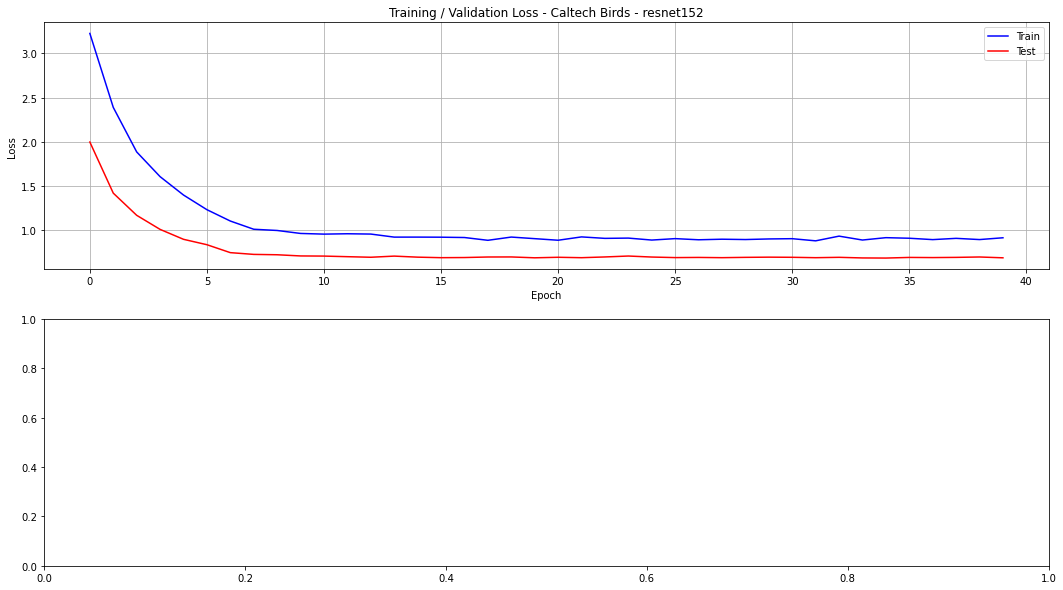

In [15]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model_name))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model_name))
plt.legend()

plt.show()

In [ ]:
save_model_full(model=model_ft, PATH='models/classification/caltech_birds_resnet152_full.pth')
save_model_dict(model=model_ft, PATH='models/classification/caltech_birds_resnet152_dict.pth')

In [16]:
history

{'epoch': [0,
  0,
  1,
  1,
  2,
  2,
  3,
  3,
  4,
  4,
  5,
  5,
  6,
  6,
  7,
  7,
  8,
  8,
  9,
  9,
  10,
  10,
  11,
  11,
  12,
  12,
  13,
  13,
  14,
  14,
  15,
  15,
  16,
  16,
  17,
  17,
  18,
  18,
  19,
  19,
  20,
  20,
  21,
  21,
  22,
  22,
  23,
  23,
  24,
  24,
  25,
  25,
  26,
  26,
  27,
  27,
  28,
  28,
  29,
  29,
  30,
  30,
  31,
  31,
  32,
  32,
  33,
  33,
  34,
  34,
  35,
  35,
  36,
  36,
  37,
  37,
  38,
  38,
  39,
  39],
 'train_loss': [3.2277253734536435,
  2.388307583662204,
  1.882707371646498,
  1.6019210753776567,
  1.3932783668105666,
  1.2269834080337483,
  1.0981375364052839,
  1.0048343398231325,
  0.9909793860442169,
  0.9572278349090108,
  0.9495910000196488,
  0.9536937873364291,
  0.9501587064973426,
  0.9155672166818454,
  0.9157184771310898,
  0.9147107803228898,
  0.9109939937198563,
  0.8794236969144336,
  0.9161299881157097,
  0.8980909749432966,
  0.8801103585713858,
  0.9180340165490503,
  0.9013834195531604,
  0.90445634